ESCI 895- Final Project- Mississippi River Sediment Deposition, 
Amelea Hauer, 
Fall 2025 
---------------------------------------------------------------------------------------------

MIT License

Copyright (c) 2025 Amelea Hauer

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

---------------------------------------------------------------------------------------------
Introduction: This final project is on the Mississippi River's estimated annual sediment deposition into the Gulf of Mexico. In the project, data analysis will be done using python coding to estimate annual sediment flux from the Mississippi river into the Gulf of Mexico with data taken at the USGS Baton Rouge monitoring station, which is the last USGS station before the Gulf of Mexico. Statistical analyses will be done to explore the discharge, sediment fluxes, sediment transport, and seasonality of the data. This project has applicability to the world outside of just python, that being the coastline of of Louisiana and surrounding states in the Gulf of Mexico. The deposition and reworking of sediments is crucial in preserving the shoreline from erosional processes (high-energy beach environments, storm-surge, precipitation/storm outwash, etc.). The artifical levees of the Mississippi have helped to prevent flooding events along the Mississppi River, but have in return disconnected the natural processes of floodplains. The nearby floodplains and coasts have been decreasing in surface area and elevation due to the levees disrupting sediment deposition. This has caused large scale water inundation coupled with sea level rise and landward elevation fall. The Mississippi river has been anthropogenically imapcted by more than just by the leeves, it has intermittent dams along its continuum. The dams effect the river's veolcity, discharge (locks), and sediment transport. Therefore, the natural processes of the river have been changed overtime and studying the sediment deposition has improtant links to the ecosystem, natural habitats, coastline, and anthropogenic factors.

---------------------------------------------------------------------------------------------
Research Question: What is the sediment flux delivered to the Gulf of Mexico by the Mississippi River?

------------------------------------------------------------------------------------------------

*Has the sediment flux changed throughout the study? (ex:increased or decreased)

*Is there a significant correlation of increased discharge with increased sediment transport? 

*Is there seasonality shown in the data?

------------------------------------------------------------------------------------------------

Data Used includes USGS: monitoring station gauge, Mississippi River at Baton Rouge, LA - USGS-07374000 

River Discharge : the volume of water flowing per unit of time
*USGS parameter code : 00060

Turbidity : a measure of how much suspended solid is in the water volume. In units of 1 NTU (Nephelometric Turbidity Unit), which is a measure of how much suspended particles are in the water volume, measured by a nephelometer, a scientific device that shoots a light beam at a 90 degree angle through the water and the light scatter is measured. The more scatter = higher NTU = higher turbidity
*USGS parameter code : 63680

Below displays the data used from the USGS file. The mean values were used in this study rather than the maximums & minimums which were disregarded. That is because the means better captures the "story" of the data.

        TS   parameter     statistic     Description
        
    215574       63680     00003     Turbidity, water, unfiltered, monochrome near infra-red LED light, 780-900 nm, detection angle 90 +-2.5 degrees, formazin nephelometric units (FNU) (Mean)
    
     61176       00060     00003     Discharge, cubic feet per second (Mean)
------------------------------------------------------------------------------------------

Study site: Mississippi River at Baton Rouge, LA. 
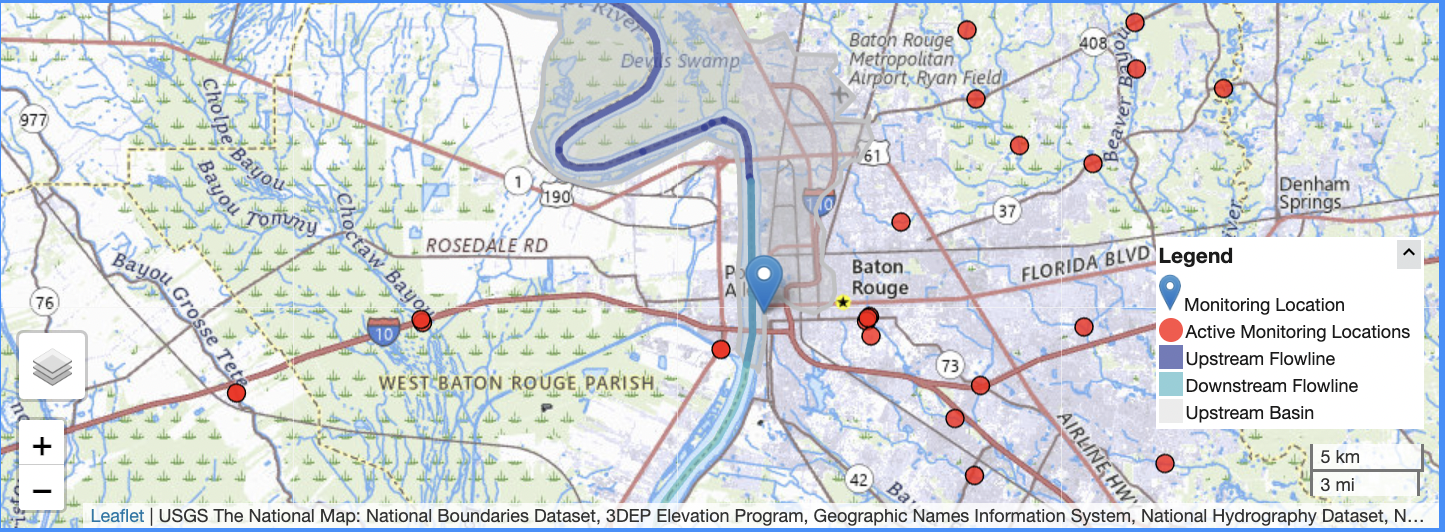
Image 1: Above depicts the location of the USGS station from the USGS site. The monitoring station is shown by the light blue pin. 

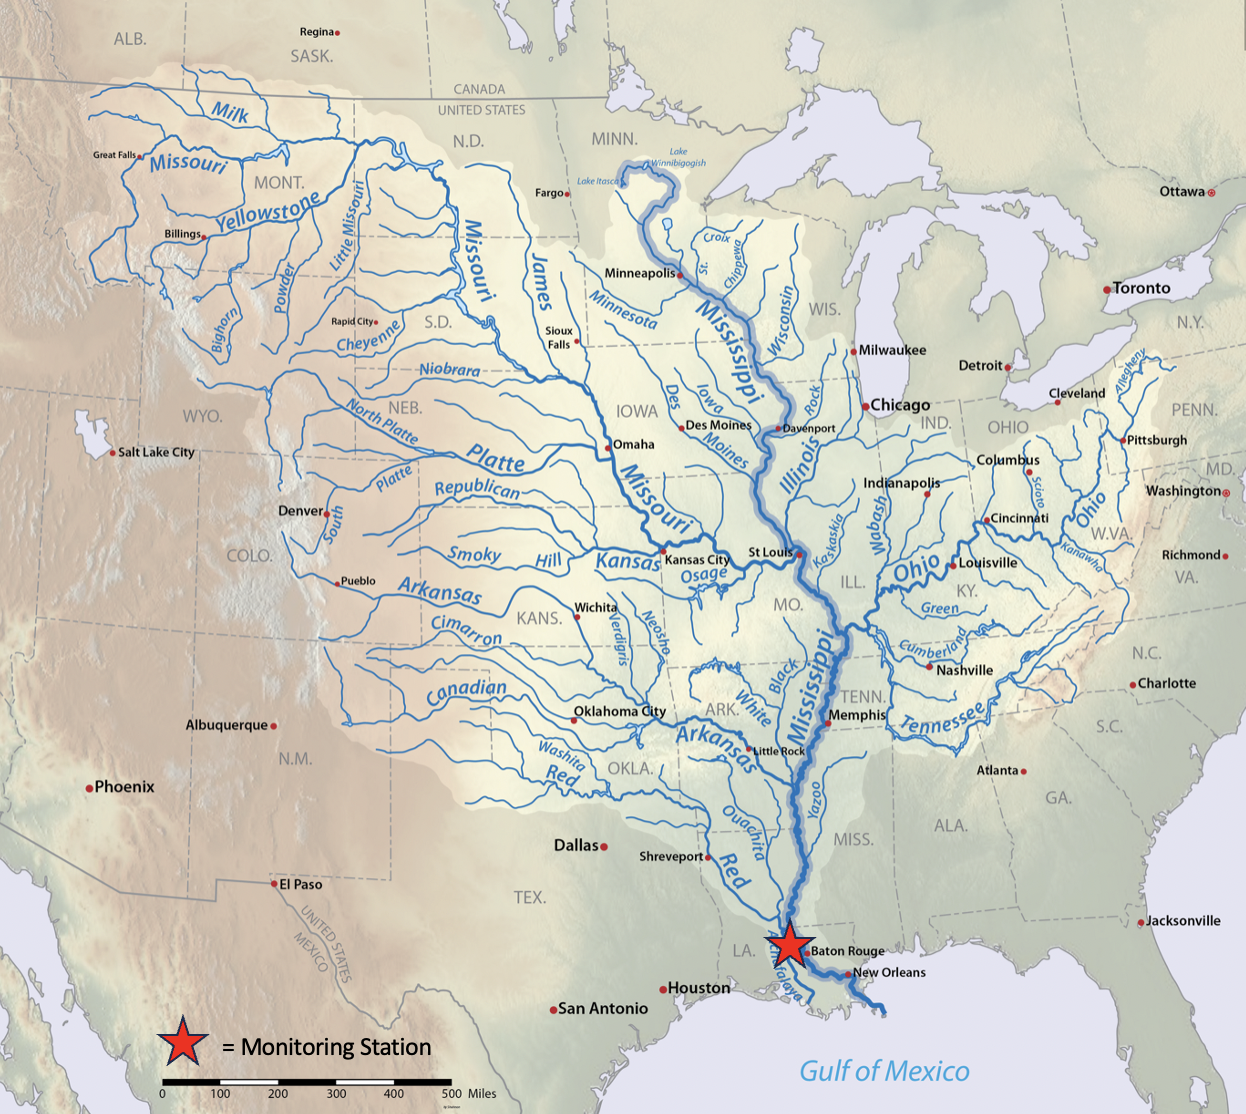 Image 2: Showing the location of Baton Rouge, LA, in comparison to the USA, also including the pathway of the entire Mississippi and its feeding waterways. The monitoring station in this dataset is one of the most southern stations on the Mississippi and was chosen for that reason, in hopes of capturing a realistic and accurate number of accumulated sediment transport, which is close to the terminus and is not affected by tides. 

Imports

In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as plotdate
import matplotlib.pyplot as plt
import sys 
import os
from pathlib import Path
folder_path = Path(os.getcwd()).parent.parent/'src'
sys.path.append(folder_path)
from scipy import stats

Parameters

In [69]:
cwd = os.getcwd()
data_usgs = Path(cwd)/ 'USGS data.txt'

in_to_cm = 2.54 #conversion of inch to cm 
sec_to_day = 60 * 60 * 24 #seconds in a day
ft3_to_m3 = 0.0283168 #conversion for ft3 to m3 
ft_to_m = 0.3048 #conversion from foot to m 
drainage_area = 1125810 #square miles
mi2_to_m2 = 2589988 #miles^2 to meters^2

reading in USGS data...
This function's purpose is to read in the USGS data from the Baton Rouge, LA monitoring gauge. The gauge's data includes: discharge (converted from ft3/s -> m/day) and turbidity (NTU). The data in this function will be used in calcualtions and plotting further in along in the coding project. 

((ft^3/s)/miles^2) * (0.028m^3/1ft^3) * (1 mile^2/2,589,988m^2) * (24hrs*60mins*60secs)) = m/day

In [73]:
#%%reading in USGS data
def read_in_usgs(filename):  
    """
    Parameters
    ----------
    filename : USGS data (in tab-deliminated form(txt))
    
    Returns   
    -------    
    dataframe with datetime as index, turbidity, and discharge
    df with datetime index, discharge (ft3/s)
    turbidity (NTU), water year, and discharge converted m/day)
    """
    #read data in   
    
    usgs_data = pd.read_csv(filename, comment="#", sep="\t", skiprows=36) #want to skip lines until headings
    usgs_data = usgs_data.iloc[1:,:]
    
    #convert datetime to index
    
    usgs_data["datetime"] = pd.to_datetime(usgs_data["datetime"], errors='coerce') #make datetime into real dates and time
    usgs_data.set_index("datetime", inplace=True) #set new index as datetime
    
    #cols to keep that are needed (USGS codes for discharge, turbidity)
    cols_to_keep = [] #to store cols I want 
    
    for name in usgs_data.columns.tolist():  # discharge and turbidity data, only keeping mean values, throwing out max and min values
        if ((("00060" in name) or ("63680" in name))
            and (("00003" in name) and ("cd" not in name))):
            cols_to_keep.append(name)    
    
             
    good_data= usgs_data[cols_to_keep].apply(pd.to_numeric, errors='coerce') #puts good columns in good_data df, also makes them numbers
            
    #renaming cols 
    
    new_names = {} #makes it a "dictionary" to put new names in 
    for name in good_data.columns:
        if "00060" in name:
            new_names[name] = "discharge (ft^3/s)"
        elif "63680" in name:
            new_names[name] = "Turbidity"
        else:
            new_names[name] = name
            
    good_data.rename(columns=new_names, inplace=True)
    
    #conversions 
    
    def vol_ft3_to_area_m(discharge_ft3s):
            vol_ft3 = discharge_ft3s * sec_to_day
            discharge_m = discharge_ft3s * ft3_to_m3  # ft3 -> m3
            return discharge_m
       
    if "discharge (ft^3/s)" in good_data.columns:
        good_data["discharge_m/day"] = vol_ft3_to_area_m(good_data["discharge (ft^3/s)"]) #discharge in m/day units
    
    #water year conversion
     
    good_data['wateryear'] = np.where(good_data.index.month >= 10,   #definition october 1 (year)- september 30 (year+1))
                            good_data.index.year +1,
                            good_data.index.year) #water year parameters, switch from month 9 to 10 
    

    good_data = good_data.loc["2015-10-01" : "2025-09-30"] #want data for full water years
    
    return(good_data)

#reassign dataframe, use good_data (more simplified)
good_data = read_in_usgs(data_usgs)


In [76]:
#%% linear regression calculation 

def lin_reg(x,y, xlabel, ylabel, title):
    """
    scatter plot with regression
    best fit line calculated using linear and theil-sen techniques
    confidence interval for regression slope using linear and theil-sen technqiues 
    p value for linear and theil-sen techniques
    
    """
    new_df = pd.DataFrame({'x': x , 'y': y }).dropna()
    
    x_good = new_df['x'].values #no nans 
    y_good = new_df['y'].values #no nans
    
    #parametric linear regression
    lsq = stats.linregress(x_good, y_good)

    # Parametric Linear Regress
    lsq = stats.linregress(x_good, y_good)
    print(f"Parametric linear regression: {y_good} vs {x_good}")
    print(f"slope: {lsq.slope:.3f}")
    print(f"intercept: {lsq.intercept:.3f}")
    print(f"r-value: {lsq.rvalue:.3f}")
    print(f"p-value: {lsq.pvalue:.3e}")
    print(f"standard error: {lsq.stderr:.3f}")
    print(f"95% CI slope: [{lsq.slope - 2*lsq.stderr:.3f}, {lsq.slope + 2*lsq.stderr:.3f}]")

    # Nonparametric Theil–Sen Regression 
    ts = stats.theilslopes(y_good, x_good, 0.95)
    print(f" Theil–Sen regression:")
    print(f" slope: {ts.slope:.3f}")
    print(f" intercept: {ts.intercept:.3f}")
    print(f" 95% CI slope: [{ts.low_slope:.3f}, {ts.high_slope:.3f}]")

    # Kendall Tau
    tau = stats.kendalltau(x_good, y_good)
    print(f" Kendall Tau correlation: {tau.statistic:.3f}")
    print(f"  p-value: {tau.pvalue:.3e}")

    #Plot 
    plt.figure()
    plt.scatter(x_good, y_good, color='red', label='data')

    #Fit lines
    x_fit = np.linspace(np.min(x_good), np.max(x_good), 100)
    y_fit_lin = lsq.intercept + lsq.slope * x_fit
    y_fit_ts = ts.intercept + ts.slope * x_fit

    plt.plot(x_fit, y_fit_lin, color='blue', label='Linear regression (parametric)')
    plt.plot(x_fit, y_fit_ts, color='purple', linestyle='--', label='Theil–Sen (non-parametric)')

    plt.xlabel(xlabel) 
    plt.ylabel(ylabel) 
    plt.title(title if title else f"{y_good} vs {x_good}") 
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

-----------------------------------------------------------------------
The concentration calcualtion used in this project was borrowed from the paper "A hyperspectral view of the nearshore Mississippi River Delta: Characterizing suspended particles in coastal wetlands using imaging spectroscopy" by Harringmeyer et al in 2024. 

Concentration calculation 
EQUATION: TSS = 1.913 * Turbidity- 2.141  (Harringmeyer et al 2024)

turbidity in formazin nephelometric units,
TSS = total suspended solids 

In [79]:

    good_data['tss'] = 1.913 * good_data['Turbidity'] - 2.141 #calculated tss from turbidity 
    

In [84]:
# %% calculations

types = ['discharge_m/day', 'tss']  # variables that calculations will be based off

for variables in types:
    # whole study (all years) calculations
    average_whole = good_data[variables].mean()
    min_whole = good_data[variables].min()
    max_whole = good_data[variables].max()

    good_data[f'average of {variables} in whole study'] = average_whole
    good_data[f'minimum of {variables} in whole study'] = min_whole
    good_data[f'maximum of {variables} in whole study'] = max_whole

    # water year calculations
    average_wy = good_data.groupby('wateryear')[variables].mean()
    min_wy = good_data.groupby('wateryear')[variables].min()
    max_wy = good_data.groupby('wateryear')[variables].max()

    # add per-water-year values back to dataframe
    good_data[f'average of {variables} in wateryear'] = good_data['wateryear'].map(average_wy)
    good_data[f'minimum of {variables} in wateryear'] = good_data['wateryear'].map(min_wy)
    good_data[f'maximum of {variables} in wateryear'] = good_data['wateryear'].map(max_wy)

flux = concentration x discharge, so sediment flux = tss x discharge 

In [87]:
#%% Calculating sediment flux  

good_data['sediment_flux'] = good_data['tss'] * good_data['discharge_m/day'] 
                                                              

Season date ranges for binning the data and exploring seasonality, Winter = Jan, Feb, Mar 01-01 : 03:31, Spring = April, May, June 04-01 : 06-30, Summer = July, Aug, Sept 07-01 : 09-30, Fall = Oct, Nov, Dec 10-01 : 12:31



In [94]:
#%%Binning seasons 

def season(month):
    if month in [1, 2, 3]:
        return 'winter'
    elif month in [4, 5, 6]:
        return 'spring'
    elif month in [7, 8, 9]:
        return 'summer'
    elif month in [10, 11, 12]:
        return 'fall'

good_data['season'] = good_data.index.month.map(season) #putting season names into df

In [130]:
#%%seasonal pivot table for plotting 

seasonal_flux_table = good_data.pivot_table(index='wateryear',columns='season',
                      values=['sediment_flux','discharge_m/day'])

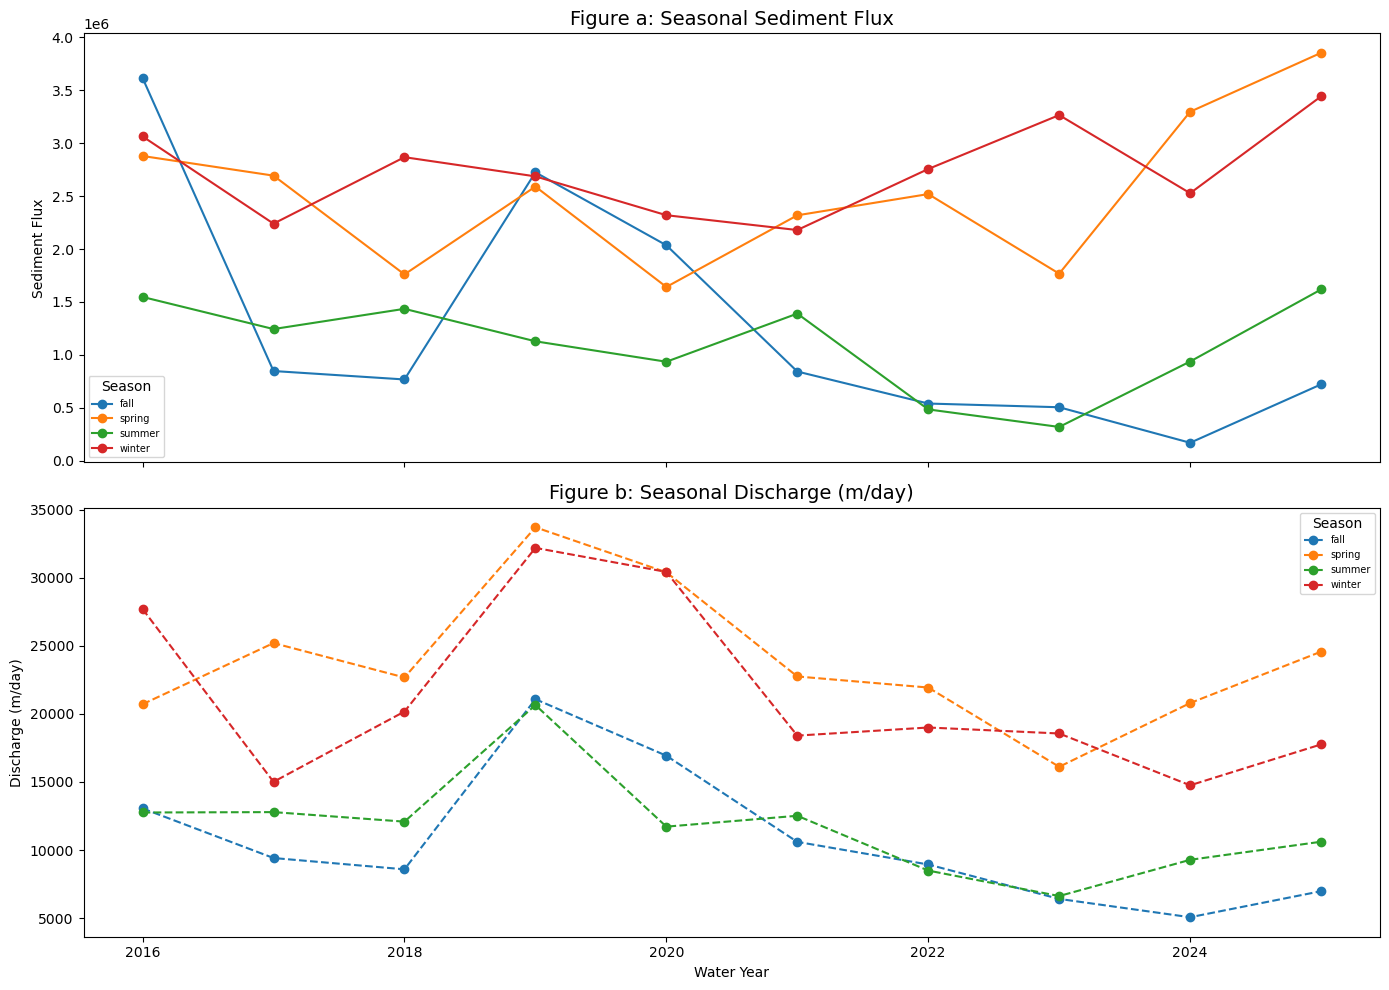

In [102]:
#%%Subplot Figure of seasonal sed flux and discharge 

fig, axs = plt.subplots(2,1,figsize=(14, 10), sharex=True)
axs = axs.flatten()


axs[0].set_title("Figure a: Seasonal Sediment Flux", fontsize=14) #sediment flux seasonal 

for season in seasonal_flux_table['sediment_flux'].columns:
    axs[0].plot(seasonal_flux_table.index, seasonal_flux_table['sediment_flux'][season],
    marker='o',label=season)
    
axs[0].set_ylabel("Sediment Flux")
axs[0].legend(title="Season", fontsize=7)


axs[1].set_title("Figure b: Seasonal Discharge (m/day)", fontsize=14) #seasonal discharge 

for season in seasonal_flux_table['discharge_m/day'].columns:
    axs[1].plot(seasonal_flux_table.index,seasonal_flux_table['discharge_m/day'][season],
    marker='o', linestyle="--",label=season)

axs[1].set_ylabel("Discharge (m/day)")
axs[1].set_xlabel("Water Year")
axs[1].legend(title="Season", fontsize=7)

plt.tight_layout()
plt.show()


Parametric linear regression: [2732756.2786048  2928506.0128512  2753178.0715968  ...  206212.5936288
  175025.86329536  197992.9203504 ] vs [13365.5296 13931.8656 14554.8352 ...  4332.4704  4360.7872  4389.104 ]
slope: 94.545
intercept: 265528.704
r-value: 0.603
p-value: 0.000e+00
standard error: 2.119
95% CI slope: [90.307, 98.783]
 Theil–Sen regression:
 slope: 115.074
 intercept: -85428.215
 95% CI slope: [111.294, 118.847]
 Kendall Tau correlation: 0.585
  p-value: 0.000e+00


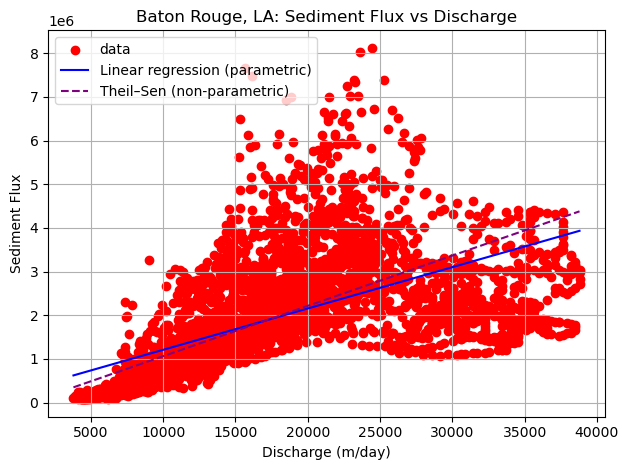

In [106]:
#%%Figure: Sediment flux vs discharge

lin_reg(good_data['discharge_m/day'], good_data['sediment_flux'],
        xlabel='Discharge (m/day)', ylabel='Sediment Flux',
        title='Baton Rouge, LA: Sediment Flux vs Discharge')

Parametric linear regression: [2630981.65052258 1737294.2833721  1702125.36813297 2279775.2250677
 1734593.51079246 1678420.45860683 1577681.73257514 1504882.13647364
 1763792.56467105 2406932.64690382] vs [2016 2017 2018 2019 2020 2021 2022 2023 2024 2025]
slope: -30179.532
intercept: 62879392.014
r-value: -0.235
p-value: 5.127e-01
standard error: 44056.087
95% CI slope: [-118291.705, 57932.641]
 Theil–Sen regression:
 slope: -31922.510
 intercept: 66235375.674
 95% CI slope: [-108398.636, 28457.369]
 Kendall Tau correlation: -0.244
  p-value: 3.807e-01


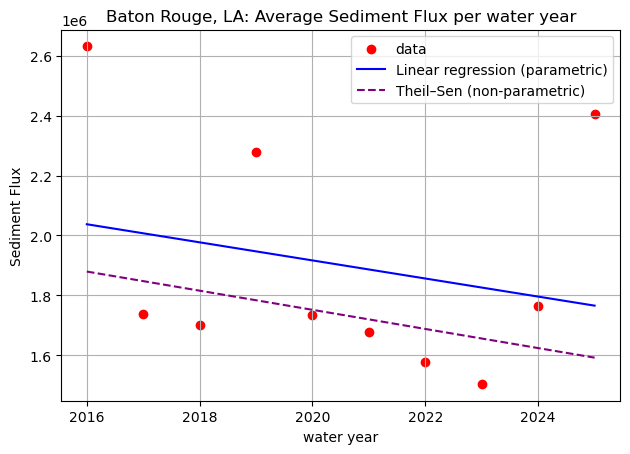

In [108]:
#%%Figure sediment flux vs water year

sed_flux_avg = good_data.groupby('wateryear')['sediment_flux'].mean() #taking avg sed flux per water year 

lin_reg(sed_flux_avg.index, sed_flux_avg.values,
        xlabel='water year', ylabel='Sediment Flux',
        title='Baton Rouge, LA: Average Sediment Flux per water year')


C = a*Q^b

One of the most widely applied C-Q analyses is the power-law relationship (C = aQb), where C and Q are regressed in log-log space, and the parameters a (y-intercept) and b (slope) are derived.

Wymore, Adam S., et al. "Revisiting the Origins of the Power-Law Analysis for the Assessment of Concentration-Discharge Relationships." Water Resources Research, vol. 59, no. 8, July 2023, e2023WR034910. AGU Publications, doi:10.1029/2023WR034910.

Woman & Miller use a transport formula : 𝑇 = 𝑎𝑄^𝑏 , Where : T = sediment transport, Q = discharge, a, b = coefficients from fitting log–log regression. 

In [184]:
#%% Woman & Miller Plot ((sed flux (dashed), sed transport (power-law relationship), streamflow))

Q = good_data['discharge_m/day'] #discharge in m/day 
T = good_data['sediment_flux']   # sediment flux

filter = (Q > 0) & (T > 0) & np.isfinite(Q) & np.isfinite(T) #had no values in cols, so filtering out 
Q_filter = Q[filter]
T_filter = T[filter]

coeffs = np.polyfit(np.log(Q_filter), np.log(T_filter), 1) # caclulating: log(T) = log(a) + blog(Q)

b = coeffs[0]
a = np.exp(coeffs[1])

good_data['sed_transport'] = a * (Q ** b) #sediment transport calculation 

#CHECK UNITSSSSSSSSSS


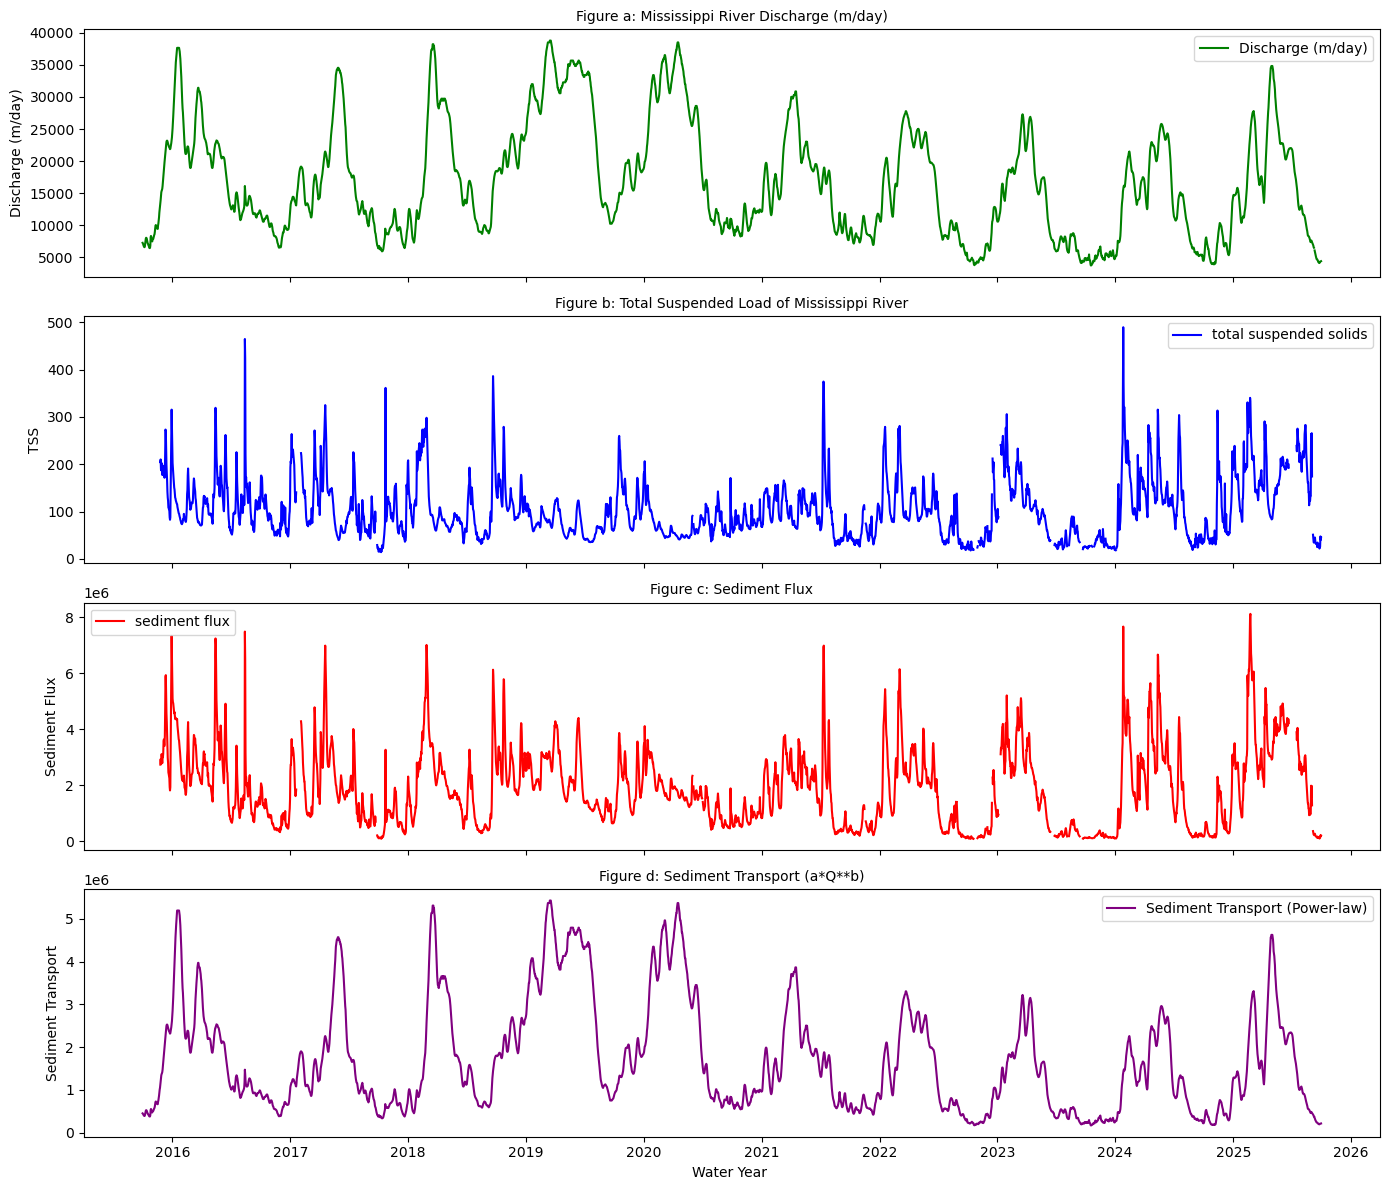

In [211]:
#%% #Timseries subplot of discharge, sed flux, sed transport 

fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
axs = axs.flatten()

Q  = good_data['discharge_m/day']
T  = good_data['sediment_flux']
ST = good_data['sed_transport']

axs[0].plot(good_data.index, Q,linestyle='-', color='green', label='Discharge (m/day)') #discharge m/day
axs[0].set_title("Figure a: Mississippi River Discharge (m/day)", fontsize=10)
axs[0].set_ylabel("Discharge (m/day)")
axs[0].legend()

axs[1].plot(good_data.index, good_data["tss"],linestyle='-', color="blue", label= 'total suspended solids')
axs[1].set_title("Figure b: Total Suspended Load of Mississippi River",fontsize=10) #NEED UNITS and to be correct 
axs[1].set_ylabel("TSS")
axs[1].legend()

axs[2].plot(good_data.index, T,linestyle='-', color='red', label = 'sediment flux') #sediment flux
axs[2].set_title("Figure c: Sediment Flux", fontsize=10)
axs[2].set_ylabel("Sediment Flux")
axs[2].legend()

axs[3].plot(good_data.index, ST,linestyle='-', color='purple',label='Sediment Transport (Power-law)') #Sed transport (power-law model)
axs[3].set_title("Figure d: Sediment Transport (a*Q**b)", fontsize=10)
axs[3].set_ylabel("Sediment Transport")
axs[3].set_xlabel("Water Year ")
axs[3].legend()

plt.tight_layout()
plt.show()


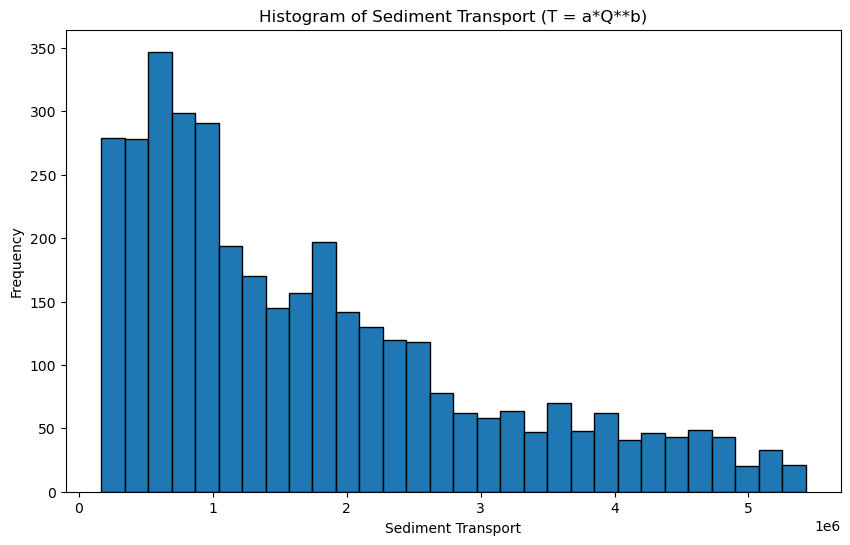

In [208]:
#%%Histogram of Sediment Transport (T = a*Q**b)
plt.figure(figsize=(10,6))
plt.hist(good_data['sed_transport'].dropna(),bins=30,edgecolor='black')

plt.title("Histogram of Sediment Transport (T = a*Q**b)", fontsize=12)
plt.xlabel("Sediment Transport")
plt.ylabel("Frequency")

plt.show()

FREQUENCY UNITS???

Potenial summarized results section:

Discussion : Jupyter notebook contains a markdown cell with an outline for the planned discussion and/or
    conclusion. Eventually, these sections should describe important trends and patterns that the analysis 
    reveals in your data, should consider your results in the context of previous work at other sites and/or
    produced by other analytical techniques, should describe any unexpected findings, should consider ways to 
    reduce errors or improve method, and should summarize and consider implications of your main findings. 
    Discuss whether the data support the hypothesis and the expectations that were described in the introduction.
    Explain conclusions that can be made from the results and the significance of these conclusions to other 
    scientists or watershed managers.


----------------------------------------------------------------------------------------------------------
Work Cited 

Joshua P. Harringmeyer, Nilotpal Ghosh, Matthew W. Weiser, David R. Thompson, Marc Simard, Steven E. Lohrenz, Cédric G. Fichot, A hyperspectral view of the nearshore Mississippi River Delta: Characterizing suspended particles in coastal wetlands using imaging spectroscopy, Remote Sensing of Environment, Volume 301, 2024,113943, ISSN 0034-4257, https://doi.org/10.1016/j.rse.2023.113943.

Wymore, Adam S., et al. "Revisiting the Origins of the Power-Law Analysis for the Assessment of Concentration-Discharge Relationships." Water Resources Research, vol. 59, no. 8, July 2023, e2023WR034910. AGU Publications, doi:10.1029/2023WR034910. 